In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import matplotlib.pyplot as plt
import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

def count_images_and_classes(directory):
    class_counts = {}

    # Loop through each subdirectory in the given directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        # Check if it's a directory
        if os.path.isdir(class_path):
            num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_files

    return class_counts

# Define paths to your directories
train_dir = './drive/MyDrive/Agni/dataset/train'
validation_dir = './drive/MyDrive/Agni/dataset/val'

# Get image counts and classes for training and validation directories
train_class_counts = count_images_and_classes(train_dir)
val_class_counts = count_images_and_classes(validation_dir)

# Print results
print("Training Data:")
for class_name, count in train_class_counts.items():
    print(f"Class '{class_name}': {count} images")

print("\nValidation Data:")
for class_name, count in val_class_counts.items():
    print(f"Class '{class_name}': {count} images")

Training Data:
Class 'yellowish': 432 images
Class 'whitefly': 432 images
Class 'not detected': 432 images
Class 'leaf spot': 432 images
Class 'leaf curl': 384 images

Validation Data:
Class 'not detected': 108 images
Class 'leaf curl': 96 images
Class 'whitefly': 108 images
Class 'leaf spot': 108 images
Class 'yellowish': 108 images


In [5]:
# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 5  # Healthy, Leaf Curl, Leaf Spot, Whitefly, Yellowish


In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Pastikan class_mode adalah 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Pastikan class_mode adalah 'categorical'
)

Found 2111 images belonging to 5 classes.
Found 528 images belonging to 5 classes.


In [7]:
# Debug bentuk data
x_batch, y_batch = next(train_generator)
print(f"Bentuk batch input: {x_batch.shape}")
print(f"Bentuk batch target: {y_batch.shape}")

Bentuk batch input: (32, 224, 224, 3)
Bentuk batch target: (32, 5)


In [8]:
# Menggunakan DenseNet-121 sebagai model dasar
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [9]:
# Ganti nama layer yang mengandung karakter tidak valid
for layer in base_model.layers:
    if '/' in layer.name:
        layer._name = layer.name.replace('/', '_')

# Tambahkan lapisan tambahan untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Pastikan jumlah neuron sesuai dengan jumlah kelas

# Buat model baru
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
65/65 [==============================] - 659s 10s/step - loss: 0.9091 - accuracy: 0.6787 - val_loss: 22.2564 - val_accuracy: 0.2266
Epoch 2/50
65/65 [==============================] - 186s 3s/step - loss: 0.5167 - accuracy: 0.8066 - val_loss: 2.6894 - val_accuracy: 0.4863
Epoch 3/50
65/65 [==============================] - 183s 3s/step - loss: 0.4242 - accuracy: 0.8519 - val_loss: 1.5769 - val_accuracy: 0.6484
Epoch 4/50
65/65 [==============================] - 181s 3s/step - loss: 0.3226 - accuracy: 0.8879 - val_loss: 1.2230 - val_accuracy: 0.7520
Epoch 5/50
65/65 [==============================] - 180s 3s/step - loss: 0.2979 - accuracy: 0.8884 - val_loss: 3.1098 - val_accuracy: 0.5879
Epoch 6/50
65/65 [==============================] - 177s 3s/step - loss: 0.3250 - accuracy: 0.8870 - val_loss: 8.3171 - val_accuracy: 0.3965
Epoch 7/50
65/65 [==============================] - 180s 3s/step - loss: 0.2572 - accuracy: 0.9086 - val_loss: 0.9478 - val_accuracy: 0.7637
Epoch 8/50


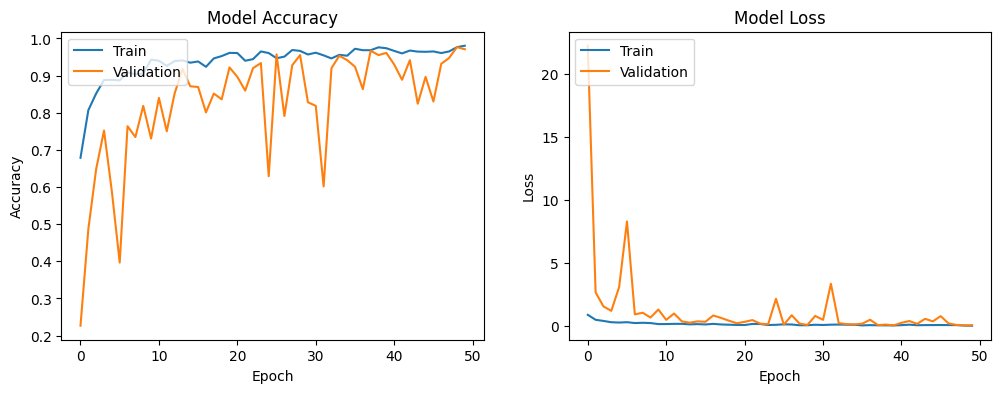

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [13]:
# Save model
model.save('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Evaluasi pada validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy:.2f}')

17/17 [==============================] - 7s 410ms/step - loss: 0.0791 - accuracy: 0.9716
Validation Accuracy: 0.97


Saving camera-01.jpeg to camera-01.jpeg
1/1 [==============================] - 2s 2s/step
Leaf Curl: 100.0% confidence
Leaf Spot: 0.0% confidence
Not Detected: 0.0% confidence
Whitefly: 0.0% confidence
Yellowish: 0.0% confidence

This Leaf Diagnosed With Leaf Curl With 100.0% confidence


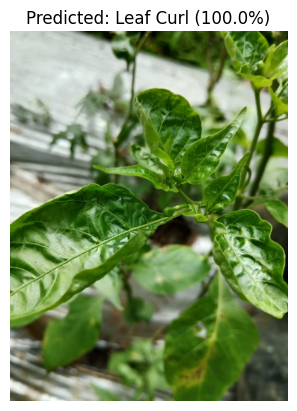

In [15]:
from google.colab import files

# Daftar nama kelas sesuai dengan label yang Anda gunakan
class_names = ['Leaf Curl', 'Leaf Spot', 'Not Detected', 'Whitefly', 'Yellowish']

# Unggah gambar
uploaded = files.upload()

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Ubah ukuran gambar menjadi (224, 224)
    x = img_to_array(img)  # Ubah gambar menjadi array numpy
    x = np.expand_dims(x, axis=0)  # Tambahkan dimensi batch
    x = x / 255.0  # Normalisasi gambar
    return x

# Prediksi untuk setiap gambar yang diunggah
for fn in uploaded.keys():
    path = fn  # Path gambar yang diunggah
    images = preprocess_image(path)

    # Prediksi gambar
    predictions = model.predict(images, batch_size=1)
    result = predictions[0]

    # Print hasil prediksi dengan probabilitas
    for count, prob in enumerate(result):
        print(f'{class_names[count]}: {round(prob * 100, 2)}% confidence')

    predicted_label = np.argmax(result)
    max_label = np.max(result)

    # Menentukan hasil prediksi berdasarkan probabilitas tertinggi
    if max_label > 0.5:
        print(f'\nThis Leaf Diagnosed With {class_names[predicted_label]} With {round(max_label * 100, 2)}% confidence')
    else:
        print('\nThis Leaf Not Found!')

    # Visualisasi gambar yang sudah diprediksi
    img = load_img(path)  # Memuat gambar asli dari path
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} ({round(max_label * 100, 2)}%)")
    plt.axis('off')
    plt.show()

In [16]:
# Muat model dari file .h5
model = load_model('final_model.h5')


In [17]:
# Tampilkan ringkasan model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']      